In [52]:
import loader
import plot
import helpers
import importlib
import joblib
importlib.reload(loader)
importlib.reload(plot)
importlib.reload(helpers)
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import defaultdict
import warnings
from matplotlib import cm
from sklearn.decomposition import FastICA, PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.random_projection import SparseRandomProjection
from kneed import KneeLocator
from scipy.stats import describe, kurtosis
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import RMSprop
from sklearn.ensemble import AdaBoostClassifier
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances, mean_squared_error
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import InterclusterDistance
from scipy.spatial.distance import cdist


In [3]:
data = loader.load_adult_data()
features = [col for col in data.columns if col != "target"]
X = data[features]
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [4]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [6]:
# Normalize input data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)
data.head()

,age,fnlwgt,education-num,capital gain,capital loss,hours per week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,country_ Puerto-Rico,country_ Scotland,country_ South,country_ Taiwan,country_ Thailand,country_ Trinadad&Tobago,country_ United-States,country_ Vietnam,country_ Yugoslavia,target
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100]

<h1>K-Means</h1>

In [121]:
km_res = defaultdict(dict)
distortions = []
run_times = []
for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(X_norm)
    run_time = time.perf_counter() - start
    y_km = km.predict(X_norm)
    km_res[k]['inertia'] = km.inertia_
    km_res[k]['time'] = run_time
    km_res[k]['sil'] = silhouette_score(X_norm, y_km, random_state=0)
    distortions.append(sum(np.min(cdist(X_norm, km.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    run_times.append(run_time)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))

km_res['dist'] = distortions
km_res['run_time'] = run_times

done k=2 in 0.321 sec
done k=3 in 0.545 sec
done k=4 in 0.555 sec
done k=5 in 0.813 sec
done k=6 in 1.002 sec
done k=7 in 1.005 sec
done k=8 in 1.194 sec
done k=9 in 1.209 sec
done k=10 in 1.408 sec
done k=12 in 1.554 sec
done k=14 in 1.819 sec
done k=16 in 1.999 sec
done k=18 in 2.763 sec
done k=20 in 2.742 sec
done k=30 in 3.523 sec
done k=40 in 4.915 sec
done k=50 in 5.721 sec
done k=60 in 7.843 sec
done k=70 in 8.224 sec
done k=80 in 9.489 sec
done k=90 in 11.516 sec
done k=100 in 12.884 sec


In [123]:
joblib.dump(km_res, "results/k_means_adult.pkl")

['results/k_means_adult.pkl']

In [127]:
km_res = joblib.load('results/k_means_adult.pkl')

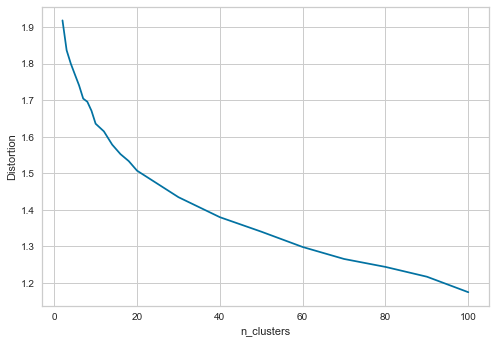

In [63]:
plt.plot(n_clusters, km_res['dist'])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

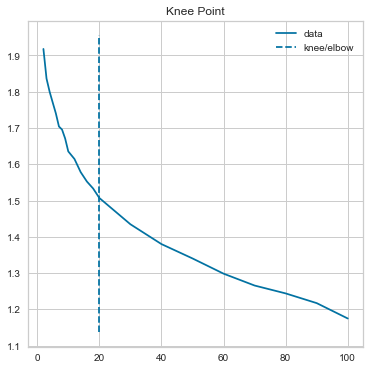

In [65]:
kneedle = KneeLocator(n_clusters, km_res['dist'], curve="convex", direction="decreasing")
kneedle.plot_knee()

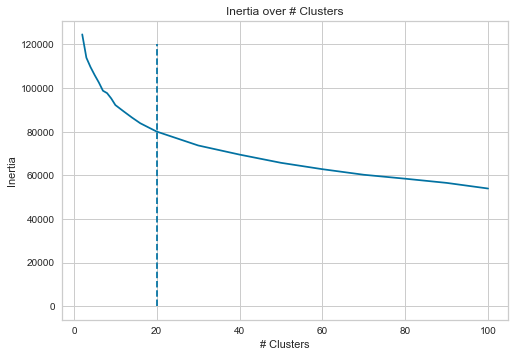

In [76]:
plt.plot(n_clusters, [km_res[k]['dist'] for k in n_clusters])
plt.xlabel('# Clusters')
plt.ylabel('Inertia')
plt.title("Inertia over # Clusters")
plt.vlines(20, 0, 120000, linestyles='dashed')
plt.show()

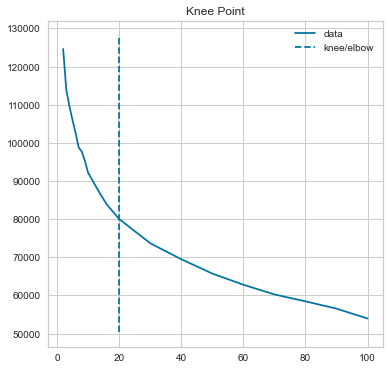

In [73]:
kneedle = KneeLocator(n_clusters, [km_res[k]['dist'] for k in n_clusters], curve="convex", direction="decreasing")
kneedle.plot_knee()

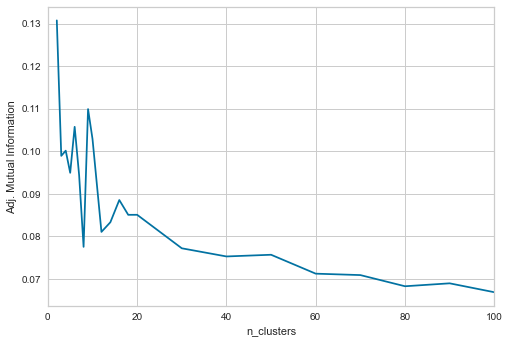

In [44]:
plt.plot(n_clusters, [km_res[k]['ami'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0, 100])
plt.show()

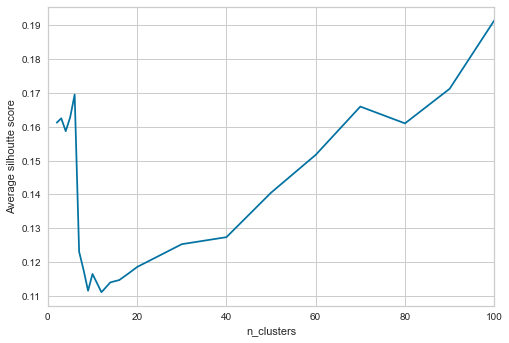

In [78]:
plt.plot(n_clusters, [km_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 100])
plt.show()

In [49]:
km_6 = KMeans(n_clusters=6,
                random_state=0,
               )
y_km_6 = km_6.fit_predict(X_norm)
colors = []
for t in y:
    if t == 0:
        colors.append('#1f77b4')
    else:
        colors.append('#ff7f0e')

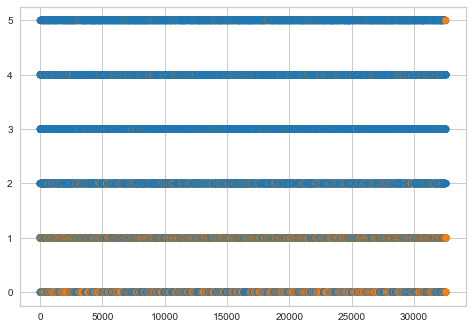

In [50]:
plt.scatter(range(1, len(X_norm)+1), y_km_6, c=colors)

In [84]:
km_20 = KMeans(n_clusters=20,
                random_state=0,
               )
y_km_20 = km_20.fit_predict(X_norm)
colors = []
for t in y:
    if t == 0:
        colors.append('#1f77b4')
    else:
        colors.append('#ff7f0e')

In [89]:
len(colors)

32561

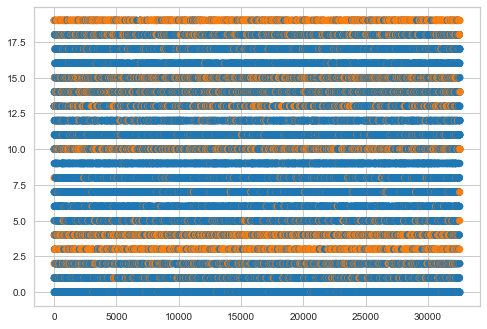

In [86]:
plt.scatter(range(1, len(X_norm)+1), y_km_20, c=colors)

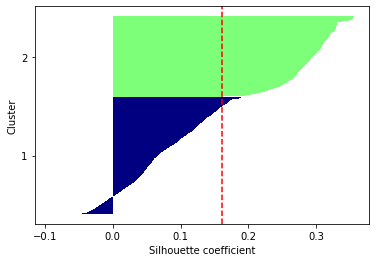

In [51]:
km_2 = KMeans(n_clusters=2,
                random_state=0,
               )
y_km_2 = km_2.fit_predict(X_norm)
cluster_labels = np.unique(y_km_2)
m_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_norm, y_km_2, metric='euclidean')
y_ax_lower, y_ax_upper = 0,0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km_2 == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / m_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, 
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color="red",
            linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

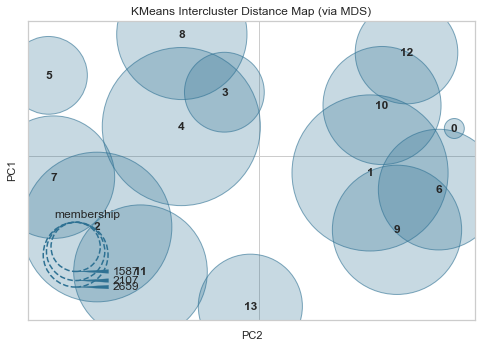

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [39]:
km_model = KMeans(n_clusters=14)
visualizer = InterclusterDistance(km_model)
visualizer.fit(X_norm)
visualizer.show()

In [35]:
np.unique(y_km_2)

array([0, 1], dtype=int32)

<h1>EM</h1>

In [140]:
em_res = defaultdict(dict)
run_times = []
for k in n_clusters:
    gm = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    gm.fit(X_norm)
    run_time = time.perf_counter() - start
    y_gm = gm.predict(X_norm)
    run_times.append(run_time)
    em_res[k]['bic'] = gm.bic(X_norm)
    em_res[k]['aic'] = gm.aic(X_norm)
    em_res[k]['ll'] = gm.score(X_norm)
    em_res[k]['time'] = run_time
    em_res[k]['sil'] = silhouette_score(X_norm, y_gm, random_state=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        em_res[k]['ami'] = ami(y, y_gm)
    print('done k=%i in %.3f sec' % (k, run_time))
em_res['run_time'] = run_times

done k=2 in 0.637 sec
done k=3 in 0.782 sec
done k=4 in 1.400 sec
done k=5 in 2.147 sec
done k=6 in 2.242 sec
done k=7 in 2.889 sec
done k=8 in 4.238 sec
done k=9 in 5.252 sec
done k=10 in 5.351 sec
done k=12 in 6.308 sec
done k=14 in 9.946 sec
done k=16 in 15.792 sec
done k=18 in 19.914 sec
done k=20 in 14.638 sec
done k=30 in 24.380 sec
done k=40 in 49.088 sec
done k=50 in 55.485 sec
done k=60 in 63.147 sec
done k=70 in 69.452 sec
done k=80 in 110.110 sec
done k=90 in 91.053 sec
done k=100 in 121.778 sec


In [141]:
joblib.dump(em_res, "results/em_adult.pkl")

['results/em_adult.pkl']

In [142]:
em_res = joblib.load('results/em_adult.pkl')

In [143]:
em_res['run_time']

[0.6373862780019408,
 0.7817128119932022,
 1.4002366740023717,
 2.14652844700322,
 2.2420510109950555,
 2.888900542995543,
 4.238324074001866,
 5.252029858005699,
 5.3505796670069685,
 6.308108240002184,
 9.946134722995339,
 15.792039797001053,
 19.91410728399933,
 14.637849650986027,
 24.379740158998175,
 49.08777558399015,
 55.48451859099441,
 63.146889729992836,
 69.4516585550009,
 110.10986401399714,
 91.05264629499288,
 121.77831446799973]

In [96]:
n_clusters

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 14,
 16,
 18,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100]

In [95]:
[em_res[k]['ll'] for k in n_clusters]

[189.64701475062583,
 196.0099092680823,
 220.14873303659516,
 225.89617828053906,
 237.31760423251214,
 245.29526441451125,
 253.3388718711725,
 265.15323175385413,
 288.54958305733163,
 335.28642297341514,
 308.7617845146119,
 342.97570835790225,
 357.96481675939134,
 361.6698660071385,
 383.77489756316754,
 423.106091556642,
 419.18969396546237,
 414.0228002807308,
 440.9321946167504,
 447.9890274455226,
 446.49285431837734,
 457.95745570625485]

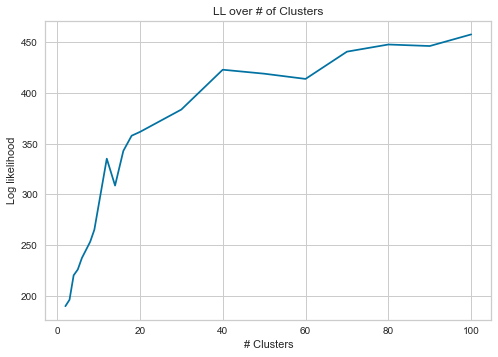

In [83]:
plt.plot(n_clusters, [em_res[k]['ll'] for k in n_clusters])
plt.xlabel('# Clusters')
plt.ylabel('Log likelihood')
plt.title('LL over # of Clusters')
plt.show()

In [90]:
em_20 = GaussianMixture(
        n_components=20,
        random_state=0,
        init_params='kmeans',
    )
y_em_20 = em_20.fit_predict(X_norm)
colors = []
for t in y:
    if t == 0:
        colors.append('#1f77b4')
    else:
        colors.append('#ff7f0e')

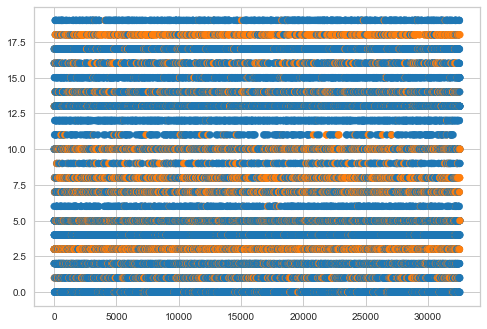

In [91]:
plt.scatter(range(1, len(X_norm)+1), y_em_20, c=colors)

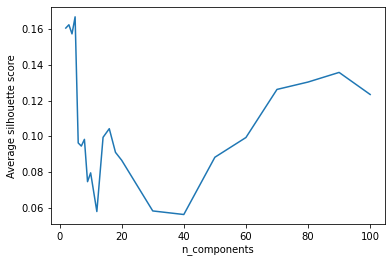

In [56]:
plt.plot(n_clusters, [em_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.show()

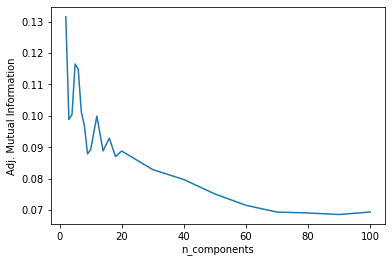

In [57]:
plt.plot(n_clusters, [em_res[k]['ami'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Adj. Mutual Information')
plt.show()

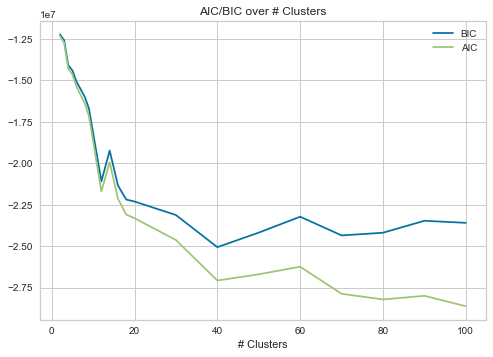

In [98]:
plt.plot(n_clusters, [em_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.title("AIC/BIC over # Clusters")
plt.xlabel('# Clusters')
plt.show()

<h1> PCA </h1>

In [37]:
component_counts = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pca_mse = []

for cc in component_counts:
    tmp_pca = PCA(
        random_state=0,
        n_components=cc,
    )
    start = time.perf_counter()
    tmp_X_tr = tmp_pca.fit_transform(X_norm)
    run_time = time.perf_counter() - start
    
    reconstructed_data = tmp_pca.inverse_transform(tmp_X_tr)
    error = mean_squared_error(X_norm, reconstructed_data)
    pca_mse.append(error)
    
    print(f'done n_components={cc} in {run_time} sec')


done n_components=2 in 0.1062214529956691 sec
done n_components=3 in 0.09380793099990115 sec
done n_components=4 in 0.1031286809957237 sec
done n_components=5 in 0.10763291500188643 sec
done n_components=6 in 0.08265765699616168 sec
done n_components=7 in 0.11595269700046629 sec
done n_components=8 in 0.1145750239957124 sec
done n_components=9 in 0.1197763579984894 sec
done n_components=10 in 0.12581209199561272 sec
done n_components=12 in 0.09568173700245097 sec
done n_components=14 in 0.10873977199662477 sec
done n_components=16 in 0.11102027099695988 sec
done n_components=18 in 0.12822067099477863 sec
done n_components=20 in 0.12838608099991689 sec
done n_components=30 in 0.14652668700000504 sec
done n_components=40 in 0.15270659000088926 sec
done n_components=50 in 0.20865680399583653 sec
done n_components=60 in 0.23919235500216018 sec
done n_components=70 in 0.2860744979989249 sec
done n_components=80 in 0.2915324060013518 sec
done n_components=90 in 0.0742977779955254 sec
done n_

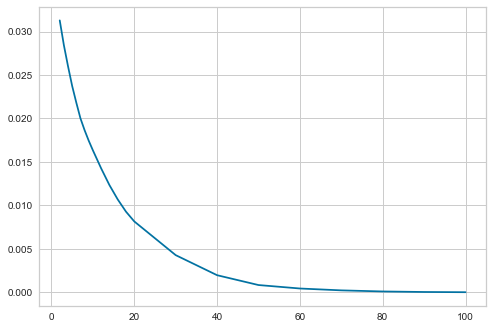

In [38]:
plt.plot(component_counts, pca_mse)

In [99]:
pca = PCA(
    n_components=None,
    random_state=0,
)
pca.fit(X_norm)

PCA(random_state=0)

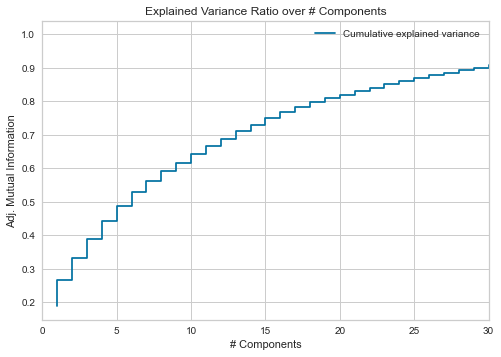

In [106]:
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), label='Cumulative explained variance')
plt.legend(loc='best')

plt.title('Explained Variance Ratio over # Components')
plt.xlabel('# Components')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0, 30])
plt.show()

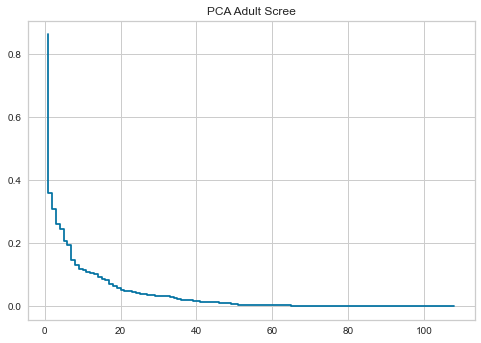

In [101]:
plt.step(range(1, pca.n_components_ + 1), pca.explained_variance_)
plt.title("PCA Adult Scree")
plt.show()

In [ ]:
kneedle = KneeLocator(range(1, svd_100.components_.shape[0] + 1), np.cumsum(svd_100.explained_variance_ratio_), curve="concave", direction="increasing")
kneedle.plot_knee()

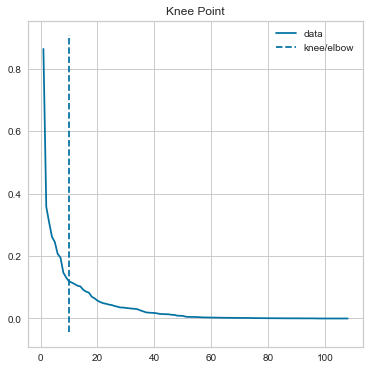

In [102]:
kneedle = KneeLocator(range(1, pca.n_components_ + 1), pca.explained_variance_, curve="convex", direction="decreasing")
kneedle.plot_knee()

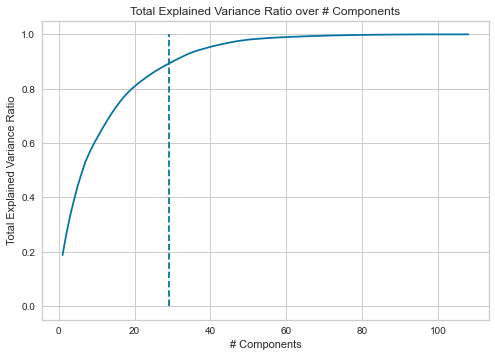

In [110]:
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.title('Total Explained Variance Ratio over # Components')
plt.xlabel('# Components')
plt.ylabel('Total Explained Variance Ratio')
plt.vlines(29, 0, 1, linestyles='dashed')

plt.show()

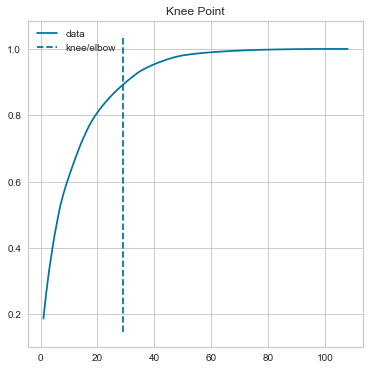

In [103]:
kneedle = KneeLocator(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), curve="concave", direction="increasing")
kneedle.plot_knee()

In [62]:
kneedle.knee

29

In [89]:
np.cumsum(pca.explained_variance_ratio_)[30]

0.9069918239273118

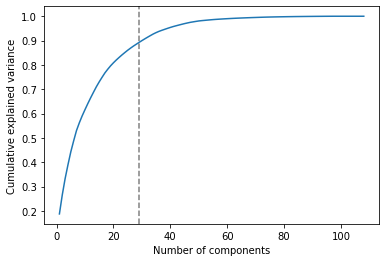

In [63]:
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
plt.axvline(29, linestyle='--', color='k', alpha=0.5)

In [64]:
pca.explained_variance_ratio_

array([0.18768478, 0.07782934, 0.06695923, 0.05693442, 0.05324837,
       0.04504521, 0.04242296, 0.03196615, 0.02852671, 0.02581718,
       0.02501415, 0.02393284, 0.02282371, 0.02233207, 0.02001666,
       0.01873094, 0.0179797 , 0.01513798, 0.01400069, 0.01243101,
       0.01143152, 0.01064443, 0.01025765, 0.00969853, 0.00936927,
       0.00869939, 0.00824765, 0.00767282, 0.00762304, 0.00736701,
       0.00714639, 0.00690438, 0.0067401 , 0.00650714, 0.00568895,
       0.00503374, 0.00430263, 0.00407121, 0.00397445, 0.00383582,
       0.00356098, 0.00316621, 0.00307545, 0.00299655, 0.00292787,
       0.00260424, 0.00252159, 0.00199851, 0.00190234, 0.00182776,
       0.00126854, 0.00111424, 0.00110114, 0.00104996, 0.00103202,
       0.00088216, 0.00077855, 0.00073896, 0.00072024, 0.00066688,
       0.00062909, 0.00061339, 0.00056288, 0.00051764, 0.00050685,
       0.00047224, 0.00046713, 0.00043994, 0.00042026, 0.0004056 ,
       0.00039567, 0.00039083, 0.00037246, 0.00032426, 0.00028

In [65]:
pca.explained_variance_

array([0.86342585, 0.35804643, 0.30803952, 0.26192136, 0.24496401,
       0.20722617, 0.19516276, 0.14705723, 0.13123438, 0.11876948,
       0.11507519, 0.11010075, 0.10499827, 0.10273656, 0.09208471,
       0.08616988, 0.08271388, 0.06964082, 0.06440881, 0.05718767,
       0.05258963, 0.04896868, 0.04718933, 0.04461717, 0.04310245,
       0.0400207 , 0.03794254, 0.03529808, 0.03506909, 0.03389122,
       0.03287628, 0.03176293, 0.03100717, 0.02993546, 0.02617145,
       0.02315724, 0.01979383, 0.01872923, 0.01828408, 0.01764634,
       0.01638195, 0.01456587, 0.01414833, 0.01378535, 0.01346937,
       0.01198057, 0.01160034, 0.00919394, 0.00875152, 0.00840844,
       0.00583581, 0.00512596, 0.00506571, 0.00483026, 0.00474772,
       0.00405828, 0.00358163, 0.00339951, 0.00331339, 0.00306792,
       0.00289407, 0.00282185, 0.00258946, 0.00238137, 0.00233169,
       0.0021725 , 0.002149  , 0.00202388, 0.00193337, 0.00186591,
       0.00182022, 0.001798  , 0.00171347, 0.00149172, 0.00132

<h1>ICA</h1>

In [11]:
standardizer = StandardScaler()
X_preprocessed = standardizer.fit_transform(X)

In [22]:
X_preprocessed

array([[ 0.03067056, -1.06361075,  1.13473876, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [ 0.83710898, -1.008707  ,  1.13473876, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [-0.04264203,  0.2450785 , -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266],
       ...,
       [ 1.42360965, -0.35877741, -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [-1.21564337,  0.11095988, -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [ 0.98373415,  0.92989258, -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266]])

In [24]:
X_preprocessed = standardizer.fit_transform(X_norm)
X_preprocessed

array([[ 0.03067056, -1.06361075,  1.13473876, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [ 0.83710898, -1.008707  ,  1.13473876, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [-0.04264203,  0.2450785 , -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266],
       ...,
       [ 1.42360965, -0.35877741, -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [-1.21564337,  0.11095988, -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266],
       [ 0.98373415,  0.92989258, -0.42005962, ...,  0.34095391,
        -0.04540836, -0.02217266]])

In [26]:
component_counts = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100, 105, 110]
mean_kurtosis = {}
ica_mse = []

for cc in component_counts:
    tmp_ica = FastICA(
        random_state=0,
        n_components=cc,
    )
    start = time.perf_counter()
    tmp_X_tr = tmp_ica.fit_transform(X_preprocessed)
    run_time = time.perf_counter() - start
    mean_kurtosis[cc] = kurtosis(tmp_X_tr).mean()
    
    reconstructed_data = tmp_ica.inverse_transform(tmp_X_tr)
    error = mean_squared_error(X_preprocessed, reconstructed_data)
    ica_mse.append(error)
    
    print(f'done n_components={cc} in {run_time} sec')

print(mean_kurtosis)


done n_components=2 in 0.3012084299998605 sec
done n_components=3 in 0.25584110999989207 sec
done n_components=4 in 0.28461570900026345 sec
done n_components=5 in 0.30014294600005087 sec
done n_components=6 in 0.27103046000001996 sec
done n_components=7 in 0.26638629099988975 sec


/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


done n_components=8 in 0.9821504719998302 sec


/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


done n_components=9 in 1.123383474000093 sec
done n_components=10 in 0.4357333299999482 sec
done n_components=12 in 0.8520536719997835 sec
done n_components=14 in 0.38655762999997023 sec
done n_components=16 in 0.3641490859999976 sec
done n_components=18 in 0.3453329260000828 sec
done n_components=20 in 0.41790780099972835 sec
done n_components=30 in 0.6513877279999178 sec
done n_components=40 in 1.0603667089999362 sec
done n_components=50 in 2.111985648999962 sec
done n_components=60 in 2.4089463989998876 sec
done n_components=70 in 2.7967565269996157 sec
done n_components=80 in 2.748942755000371 sec
done n_components=90 in 4.637236334000136 sec


/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


done n_components=100 in 11.096992182000122 sec


/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 108
  % n_components


done n_components=105 in 11.575102481000158 sec
done n_components=110 in 13.682854444999975 sec
{2: -0.529799986233456, 3: 1.8978358870197412, 4: 2.971877412536694, 5: 3.857131746581281, 6: 4.760126125920254, 7: 3.769559353899099, 8: 6.410956751426441, 9: 6.766154170703367, 10: 6.441915443538761, 12: 6.499920427591289, 14: 6.827329319289534, 16: 11.839232002602692, 18: 12.142591530492957, 20: 14.613282798890484, 30: 33.38159956841368, 40: 55.941117104638394, 50: 92.04199472784654, 60: 205.01521745097483, 70: 484.898684138523, 80: 725.5039227400131, 90: 701.4765829423046, 100: 712.1056976108237, 105: 115.95546247464486, 110: 28.030835837769033}


/Users/eoh/opt/anaconda3/envs/school/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


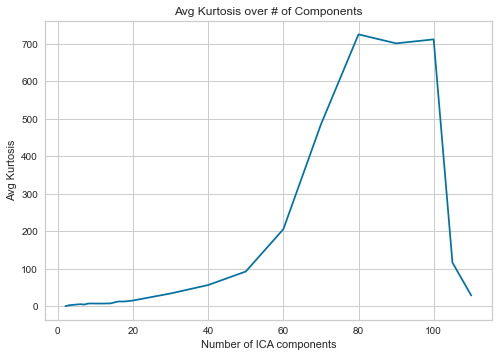

In [111]:
pd.Series(mean_kurtosis).plot()
plt.title('Avg Kurtosis over # of Components')
plt.ylabel('Avg Kurtosis')
plt.xlabel('Number of ICA components')
plt.show()

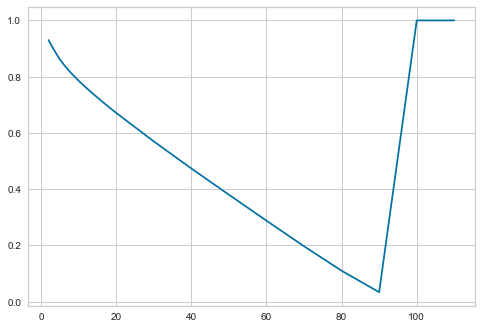

In [28]:
plt.plot(component_counts, ica_mse)

In [83]:
ica29 = FastICA(
    random_state=0,
    n_components=29,
)
X_tr29 = ica29.fit_transform(X_norm)
kurt_df29 = pd.DataFrame(kurtosis(X_tr29, axis=0), columns=['kurtosis'])
kurt_df29.sort_values(by='kurtosis', ascending=False)

,kurtosis
8,20.411268
9,17.876339
6,16.138985
5,13.933221
17,13.469859
0,13.004413
7,12.888116
2,12.808218
4,12.299355
14,12.097594


In [85]:
normed = ica29.components_[8] / np.linalg.norm(ica29.components_[8])
np.set_printoptions(suppress=True)
normed.astype(np.float)
s = pd.Series(normed)
data.drop('target', axis=1).columns[s.abs() > 0.1]

Index(['race_ Asian-Pac-Islander', 'race_ Black', 'race_ White',
       'country_ Mexico', 'country_ Philippines', 'country_ United-States'],
      dtype='object')

In [86]:
normed = ica29.components_[9] / np.linalg.norm(ica29.components_[9])
np.set_printoptions(suppress=True)
normed.astype(np.float)
s = pd.Series(normed)
data.drop('target', axis=1).columns[s.abs() > 0.1]

Index(['workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'marital status_ Separated', 'occupation_ Protective-serv'],
      dtype='object')

In [88]:
ica29.components_.shape

(29, 108)

In [84]:
ica10 = FastICA(
    random_state=0,
    n_components=10,
)
X_tr10 = ica10.fit_transform(X_norm)
kurt_df10 = pd.DataFrame(kurtosis(X_tr10, axis=0), columns=['kurtosis'])
kurt_df10.sort_values(by='kurtosis', ascending=False)

,kurtosis
6,2.663826
3,2.056896
5,1.150602
1,1.020595
8,1.018310
4,0.801206
9,0.590572
0,-1.048535
7,-1.385045
2,-1.803780


In [70]:
normed = ica10.components_[6] / np.linalg.norm(ica10.components_[6])
np.set_printoptions(suppress=True)
normed.astype(np.float)
s = pd.Series(normed)
data.drop('target', axis=1).columns[s.abs() > 0.1]

Index(['occupation_ Adm-clerical', 'race_ Asian-Pac-Islander', 'race_ Black',
       'race_ White'],
      dtype='object')

In [71]:
normed = ica10.components_[9] / np.linalg.norm(ica10.components_[9])
np.set_printoptions(suppress=True)
normed.astype(np.float)
s = pd.Series(normed)
data.drop('target', axis=1).columns[s.abs() > 0.1]

Index(['marital status_ Divorced', 'marital status_ Married-civ-spouse',
       'marital status_ Never-married', 'relationship_ Not-in-family',
       'relationship_ Own-child', 'relationship_ Unmarried'],
      dtype='object')

<h1>RP</h1>

In [113]:
component_counts = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100]
rp_res = defaultdict(dict)

rp_mse = []
mse = []
pdiffms = []
pdiffstds = []

for cc in component_counts:

    srp = SparseRandomProjection(n_components=cc)
    start = time.perf_counter()
    srp.fit(X_norm)
    run_time = time.perf_counter() - start

    components = srp.components_.toarray()
    p_inverse = np.linalg.pinv(components.T)
    reduced_data = srp.transform(X_norm)
#     reconstructed_data = reduced_data.dot(srp.components_) + np.mean(X_norm, axis = 0)

    reconstructed_data = reduced_data.dot(p_inverse)
    error = mean_squared_error(X_norm, reconstructed_data)
    rp_mse.append(error)

#     srp = SparseRandomProjection(n_components=cc)
#     Xt = srp.fit_transform(X_norm)
#     Xr = helpers.reconstructit(srp.components_, Xt)
#     mse.append(mean_squared_error(X_norm, Xr))

    print(f'done n_components={cc} in {run_time} sec')


# random_projection = SparseRandomProjection(n_components=5)

# random_projection.fit(data)
# components =  random_projection.components_.toarray() # shape=(5, 11) 
# p_inverse = np.linalg.pinv(components.T) # shape=(5, 11) 

# #now get the transformed data using the projection components
# reduced_data = random_projection.transform(data) #shape=(4898, 5) 
# reconstructed= reduced_data.dot(p_inverse)  #shape=(4898, 11) 
# assert  reduced_data.shape ==  reconstructed.shape
# error = mean_squared_error(data, reconstructed)

done n_components=2 in 0.0025901379995048046 sec
done n_components=3 in 0.0023685689957346767 sec
done n_components=4 in 0.002242878996185027 sec
done n_components=5 in 0.0020645629992941394 sec
done n_components=6 in 0.002404978993581608 sec
done n_components=7 in 0.0024264539970317855 sec
done n_components=8 in 0.002230142999906093 sec
done n_components=9 in 0.0020757729944307357 sec
done n_components=10 in 0.002771960003883578 sec
done n_components=12 in 0.00225150900951121 sec
done n_components=14 in 0.0021018020051997155 sec
done n_components=16 in 0.0027310360019328073 sec
done n_components=18 in 0.0023644419998163357 sec
done n_components=20 in 0.00215150200529024 sec
done n_components=30 in 0.0026405539974803105 sec
done n_components=40 in 0.0024845250009093434 sec
done n_components=50 in 0.0024589569948147982 sec
done n_components=60 in 0.0025651139876572415 sec
done n_components=70 in 0.003158378996886313 sec
done n_components=80 in 0.00404694999451749 sec
done n_components=9

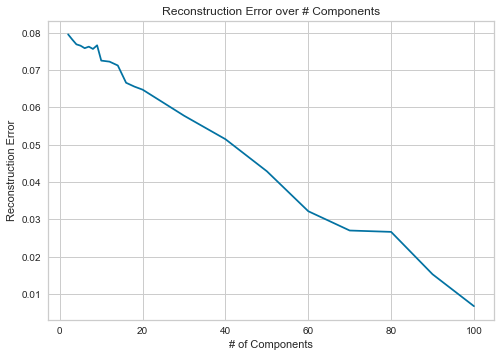

In [115]:
plt.plot(component_counts, rp_mse)
plt.xlabel('# of Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error over # Components')
plt.show()
# plt.plot(component_counts, mse)

<h1>SVD</h1>

In [63]:
component_counts = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100]
svd_mse = []

for cc in component_counts:

    svd = TruncatedSVD(n_components=cc)
    start = time.perf_counter()
    tmp_svd_Xt = svd.fit_transform(X_norm)
    run_time = time.perf_counter() - start
    
    reconstructed_data = svd.inverse_transform(tmp_svd_Xt)
    error = mean_squared_error(X_norm, reconstructed_data)
    svd_mse.append(error)
    print(f'done n_components={cc} in {run_time}')


done n_components=2 in 0.07765929700690322
done n_components=3 in 0.0803742200077977
done n_components=4 in 0.05891402700217441
done n_components=5 in 0.07920322100108024
done n_components=6 in 0.08300572399457451
done n_components=7 in 0.08603342199057806
done n_components=8 in 0.08999314901302569
done n_components=9 in 0.08518875700247008
done n_components=10 in 0.09597891999874264
done n_components=12 in 0.10961349199351389
done n_components=14 in 0.12918463899404742
done n_components=16 in 0.13237164499878418
done n_components=18 in 0.11498645000392571
done n_components=20 in 0.12771657099074218
done n_components=30 in 0.17316938799922355
done n_components=40 in 0.16988170800323132
done n_components=50 in 0.23904507300176192
done n_components=60 in 0.26639352799975313
done n_components=70 in 0.3486987710057292
done n_components=80 in 0.34119611099595204
done n_components=90 in 0.3926211660000263
done n_components=100 in 0.4515243660134729


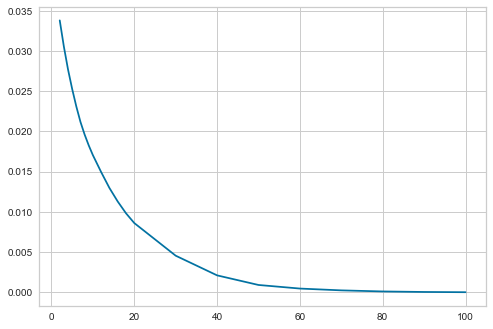

In [64]:
plt.plot(component_counts, svd_mse)
plt.show()

In [117]:
svd_100 = TruncatedSVD(n_components=100)
svd_100_Xt = svd_100.fit_transform(X_norm)

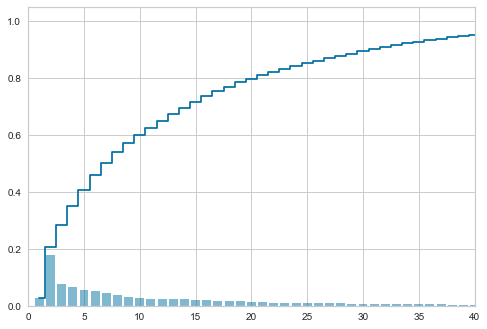

In [75]:
plt.bar(range(1, 101), svd_100.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, 101), np.cumsum(svd_100.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.xlim([0, 40])
plt.show()

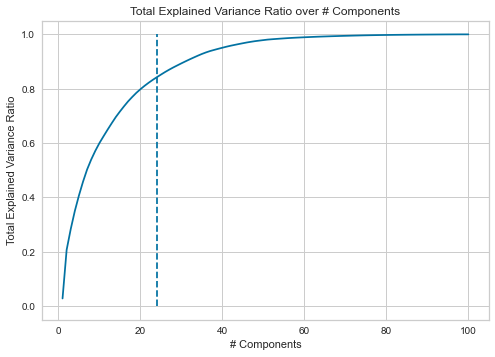

In [120]:
plt.plot(range(1, svd_100.components_.shape[0] + 1), np.cumsum(svd_100.explained_variance_ratio_))
plt.title('Total Explained Variance Ratio over # Components')
plt.xlabel('# Components')
plt.ylabel('Total Explained Variance Ratio')
plt.vlines(24, 0, 1, linestyles='dashed')

plt.show()

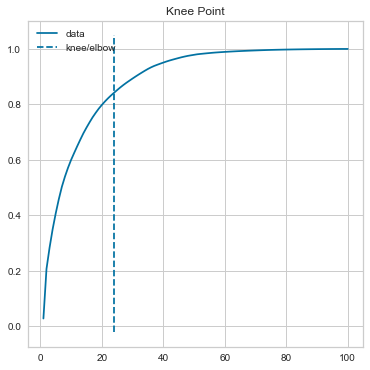

In [100]:
kneedle = KneeLocator(range(1, svd_100.components_.shape[0] + 1), np.cumsum(svd_100.explained_variance_ratio_), curve="concave", direction="increasing")
kneedle.plot_knee()

In [101]:
kneedle.knee

24

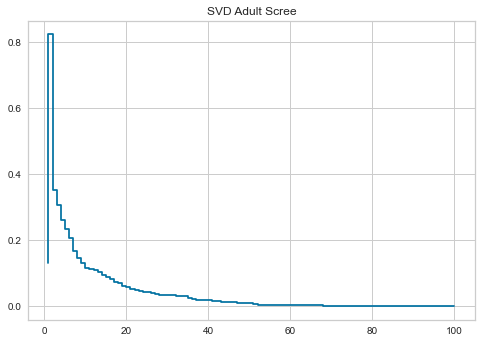

In [72]:
plt.step(range(1, 101), svd_100.explained_variance_)
plt.title("SVD Adult Scree")
plt.show()

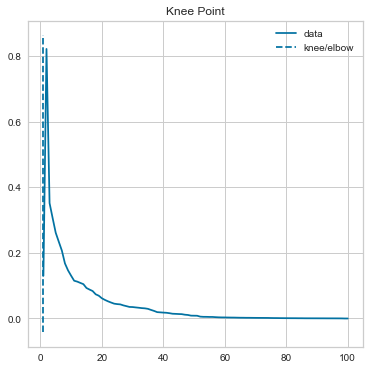

In [73]:
kneedle = KneeLocator(range(1, 101), svd_100.explained_variance_, curve="convex", direction="decreasing")
kneedle.plot_knee()

In [76]:
svd_50 = TruncatedSVD(n_components=50)
svd_50_Xt = svd_50.fit_transform(X_norm)

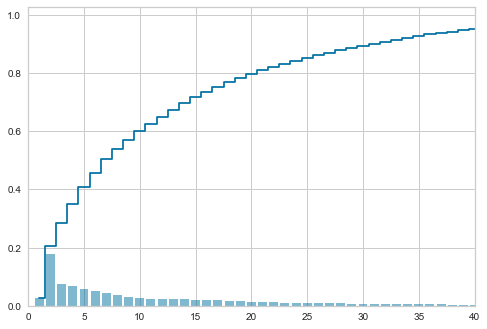

In [77]:
plt.bar(range(1, 51), svd_50.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, 51), np.cumsum(svd_50.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.xlim([0, 40])
plt.show()

<h1>K-Means with PCA</h1>

In [124]:
km_pca_res = defaultdict(dict)
distortions = []
pca_29 = PCA(
    n_components=29,
    random_state=0,
)
pca_29_Xt = pca_29.fit_transform(X_norm)
run_times = []
for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(pca_29_Xt)
    run_time = time.perf_counter() - start
    y_km = km.predict(pca_29_Xt)
    km_pca_res[k]['dist'] = km.inertia_
    km_pca_res[k]['time'] = run_time
    km_pca_res[k]['sil'] = silhouette_score(pca_29_Xt, y_km, random_state=0)
    distortions.append(sum(np.min(cdist(pca_29_Xt, km.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    run_times.append(run_time)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km_pca_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))

km_res['dist'] = distortions
km_res['run_time'] = run_times
joblib.dump(km_pca_res, "results/k_means_pca_adult.pkl")

done k=2 in 0.159 sec
done k=3 in 0.232 sec
done k=4 in 0.269 sec
done k=5 in 0.436 sec
done k=6 in 0.448 sec
done k=7 in 0.465 sec
done k=8 in 0.510 sec
done k=9 in 0.572 sec
done k=10 in 0.607 sec
done k=12 in 0.799 sec
done k=14 in 1.020 sec
done k=16 in 1.148 sec
done k=18 in 1.473 sec
done k=20 in 1.562 sec
done k=30 in 2.426 sec
done k=40 in 3.225 sec
done k=50 in 5.082 sec
done k=60 in 5.882 sec
done k=70 in 6.994 sec
done k=80 in 8.544 sec
done k=90 in 8.280 sec
done k=100 in 9.587 sec


['results/k_means_pca_adult.pkl']

In [125]:
km_pca_res['dist'] = distortions
km_pca_res['run_time'] = run_times
joblib.dump(km_pca_res, "results/k_means_pca_adult.pkl")

['results/k_means_pca_adult.pkl']

In [138]:
tmp = []
for i in range(len(km_res['run_time'])):
    tmp.append([n_clusters[i], km_res['run_time'][i], km_pca_res['run_time'][i]])

In [139]:
pd.DataFrame(data=tmp, columns=['# Clusters', 'K-Means', 'K-Means with PCA'])

,# Clusters,K-Means,K-Means with PCA
0,2,0.321148,0.158940
1,3,0.545049,0.232228
2,4,0.555078,0.268793
3,5,0.812610,0.435724
4,6,1.002234,0.447592
5,7,1.004946,0.465491
6,8,1.194117,0.510458
7,9,1.208969,0.572014
8,10,1.408122,0.606819
9,12,1.554082,0.799355


In [134]:
len(km_res['run_time'])

22

In [135]:
len(km_pca_res['run_time'])

22

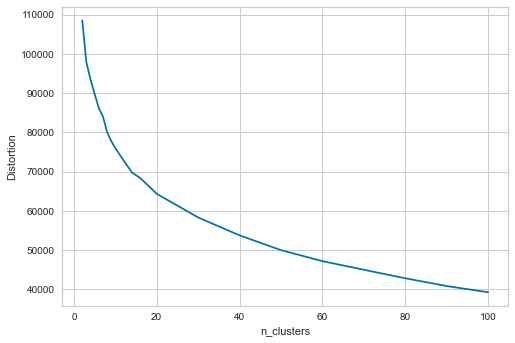

In [79]:
plt.plot(n_clusters, [km_pca_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

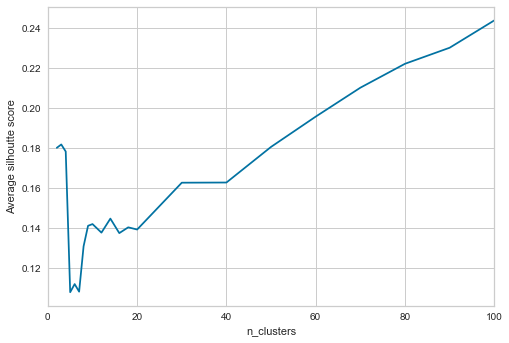

In [80]:
plt.plot(n_clusters, [km_pca_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 100])
plt.show()

<h1>K-Means with ICA</h1>

In [32]:
km_ica_res = defaultdict(dict)
ica80 = FastICA(
    random_state=0,
    n_components=80,
)
ica80_Xt = ica80.fit_transform(X_preprocessed)

for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(ica80_Xt)
    run_time = time.perf_counter() - start
    y_km = km.predict(ica80_Xt)
    km_ica_res[k]['dist'] = km.inertia_
    km_ica_res[k]['time'] = run_time
    km_ica_res[k]['sil'] = silhouette_score(ica80_Xt, y_km, random_state=0)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(km_ica_res, "results/k_means_ica_80_adult.pkl")

done k=2 in 0.208 sec
done k=3 in 0.326 sec
done k=4 in 0.433 sec
done k=5 in 0.462 sec
done k=6 in 0.512 sec
done k=7 in 0.702 sec
done k=8 in 0.874 sec
done k=9 in 0.916 sec
done k=10 in 0.815 sec
done k=12 in 1.097 sec
done k=14 in 1.151 sec
done k=16 in 1.509 sec
done k=18 in 1.468 sec
done k=20 in 1.581 sec
done k=30 in 1.939 sec
done k=40 in 2.585 sec
done k=50 in 3.418 sec
done k=60 in 4.222 sec
done k=70 in 5.236 sec
done k=80 in 7.346 sec
done k=90 in 7.452 sec
done k=100 in 8.707 sec


['results/k_means_ica_80_adult.pkl']

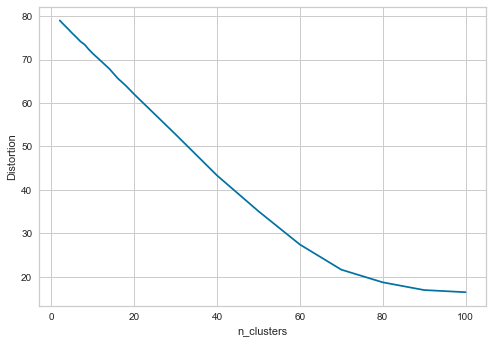

In [33]:
plt.plot(n_clusters, [km_ica_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

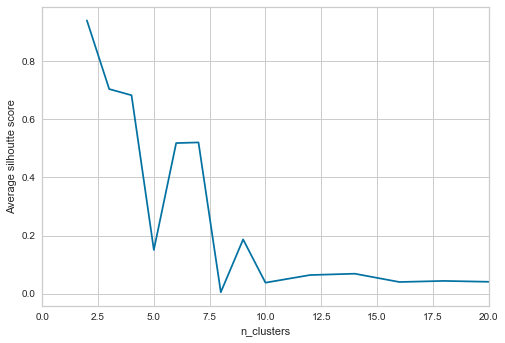

In [35]:
plt.plot(n_clusters, [km_ica_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 20])
plt.show()

<h1>K-Means with RP</h1>

In [96]:
km_rp_res = defaultdict(dict)
rp19 = SparseRandomProjection(n_components=19, random_state = 0)

rp19_Xt = rp19.fit_transform(X_norm)

for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(rp19_Xt)
    run_time = time.perf_counter() - start
    y_km = km.predict(rp19_Xt)
    km_rp_res[k]['dist'] = km.inertia_
    km_rp_res[k]['time'] = run_time
    km_rp_res[k]['sil'] = silhouette_score(rp19_Xt, y_km, random_state=0)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         km_rp_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(km_rp_res, "results/k_means_rp_adult.pkl")

done k=2 in 0.205 sec
done k=3 in 0.283 sec
done k=4 in 0.387 sec
done k=5 in 0.656 sec
done k=6 in 0.629 sec
done k=7 in 0.589 sec
done k=8 in 0.686 sec
done k=9 in 0.901 sec
done k=10 in 1.014 sec
done k=12 in 0.964 sec
done k=14 in 1.338 sec
done k=16 in 1.414 sec
done k=18 in 1.642 sec
done k=20 in 1.815 sec
done k=30 in 2.588 sec
done k=40 in 3.448 sec
done k=50 in 4.947 sec
done k=60 in 5.484 sec
done k=70 in 6.450 sec
done k=80 in 7.979 sec
done k=90 in 8.804 sec
done k=100 in 8.988 sec


['results/k_means_rp_adult.pkl']

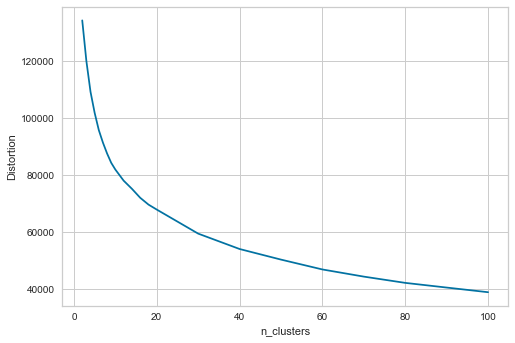

In [97]:
plt.plot(n_clusters, [km_rp_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

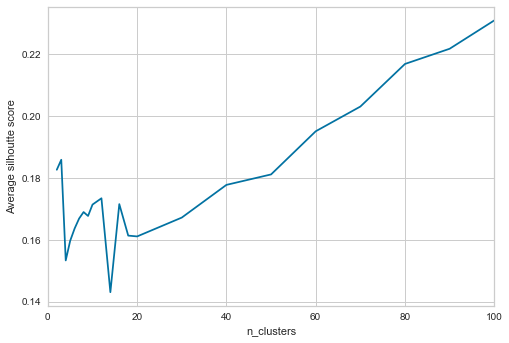

In [98]:
plt.plot(n_clusters, [km_rp_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 100])
plt.show()

<h1>K-Means with SVD</h1>

In [118]:
km_svd_res = defaultdict(dict)
svd24 = TruncatedSVD(n_components=24, random_state = 0)

svd24_Xt = svd24.fit_transform(X_norm)

for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
               )
    start = time.perf_counter()
    km.fit(svd24_Xt)
    run_time = time.perf_counter() - start
    y_km = km.predict(svd24_Xt)
    km_svd_res[k]['dist'] = km.inertia_
    km_svd_res[k]['time'] = run_time
    km_svd_res[k]['sil'] = silhouette_score(svd24_Xt, y_km, random_state=0)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         km_rp_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(km_svd_res, "results/k_means_svd_adult.pkl")

done k=2 in 0.148 sec
done k=3 in 0.203 sec
done k=4 in 0.265 sec
done k=5 in 0.352 sec
done k=6 in 0.390 sec
done k=7 in 0.542 sec
done k=8 in 0.535 sec
done k=9 in 0.579 sec
done k=10 in 0.629 sec
done k=12 in 0.888 sec
done k=14 in 1.034 sec
done k=16 in 1.025 sec
done k=18 in 1.370 sec
done k=20 in 1.436 sec
done k=30 in 2.187 sec
done k=40 in 3.157 sec
done k=50 in 3.841 sec
done k=60 in 4.454 sec
done k=70 in 4.800 sec
done k=80 in 6.062 sec
done k=90 in 6.382 sec
done k=100 in 7.406 sec


['results/k_means_svd_adult.pkl']

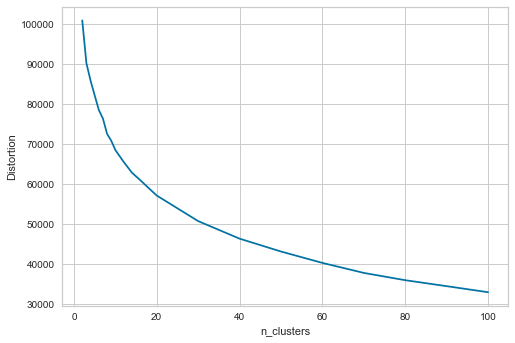

In [119]:
plt.plot(n_clusters, [km_svd_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

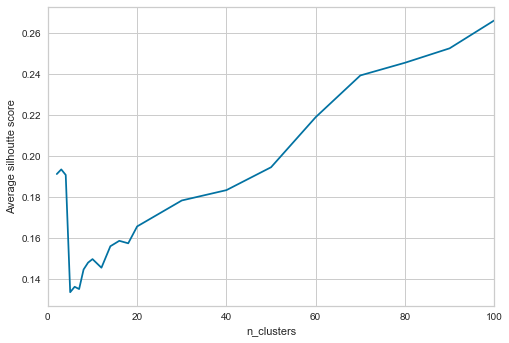

In [120]:
plt.plot(n_clusters, [km_svd_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 100])
plt.show()

In [122]:
plt.plot(n_clusters, [km_pca_res[k]['sil'] for k in n_clusters], label='PCA')
plt.plot(n_clusters, [km_ica_res[k]['sil'] for k in n_clusters], label='ICA')
plt.plot(n_clusters, [km_rp_res[k]['sil'] for k in n_clusters], label='RP')
plt.plot(n_clusters, [km_svd_res[k]['sil'] for k in n_clusters], label='SVD')


KeyError: 'sil'

<h1>EM with PCA</h1>

In [144]:
em_pca_res = defaultdict(dict)
pca_29 = PCA(
    n_components=29,
    random_state=0,
)
pca_29_Xt = pca_29.fit_transform(X_norm)
run_times = []
for k in n_clusters:
    em = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    em.fit(pca_29_Xt)
    run_time = time.perf_counter() - start
    y_em = em.predict(pca_29_Xt)
    em_pca_res[k]['bic'] = em.bic(pca_29_Xt)
    em_pca_res[k]['aic'] = em.aic(pca_29_Xt)
    em_pca_res[k]['ll'] = em.score(pca_29_Xt)
    em_pca_res[k]['time'] = run_time
    em_pca_res[k]['sil'] = silhouette_score(pca_29_Xt, y_em, random_state=0)
    run_times.append(run_time)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         km_pca_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))
em_pca_res['run_time'] = run_times
joblib.dump(em_pca_res, "results/em_pca_adult.pkl")

done k=2 in 0.235 sec
done k=3 in 0.296 sec
done k=4 in 1.100 sec
done k=5 in 1.826 sec
done k=6 in 0.600 sec
done k=7 in 1.023 sec
done k=8 in 1.127 sec
done k=9 in 1.976 sec
done k=10 in 2.776 sec
done k=12 in 5.101 sec
done k=14 in 4.538 sec
done k=16 in 3.721 sec
done k=18 in 11.019 sec
done k=20 in 9.078 sec
done k=30 in 13.330 sec
done k=40 in 16.254 sec
done k=50 in 23.422 sec
done k=60 in 37.509 sec
done k=70 in 38.503 sec
done k=80 in 35.336 sec
done k=90 in 47.299 sec
done k=100 in 49.446 sec


['results/em_pca_adult.pkl']

In [145]:
tmp = []
for i in range(len(em_res['run_time'])):
    tmp.append([n_clusters[i], em_res['run_time'][i], em_pca_res['run_time'][i]])

In [146]:
pd.DataFrame(data=tmp, columns=['# Clusters', 'EM', 'EM with PCA'])

,# Clusters,EM,EM with PCA
0,2,0.637386,0.235436
1,3,0.781713,0.295726
2,4,1.400237,1.100101
3,5,2.146528,1.826110
4,6,2.242051,0.599948
5,7,2.888901,1.023447
6,8,4.238324,1.127342
7,9,5.252030,1.975573
8,10,5.350580,2.775602
9,12,6.308108,5.101294


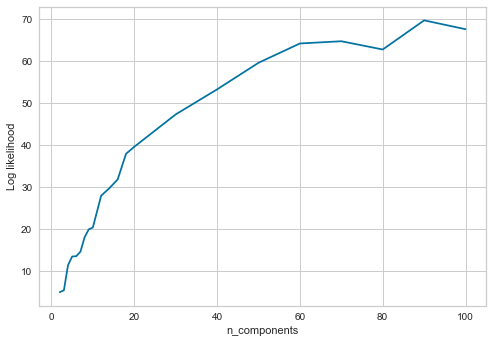

In [107]:
plt.plot(n_clusters, [em_pca_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

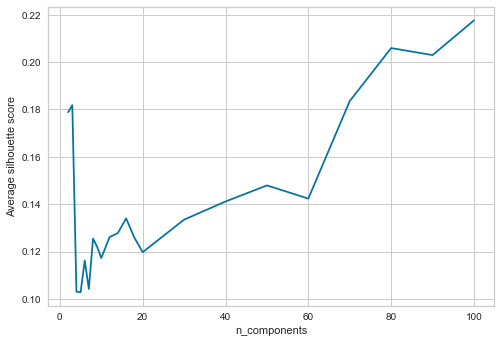

In [108]:
plt.plot(n_clusters, [em_pca_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.show()

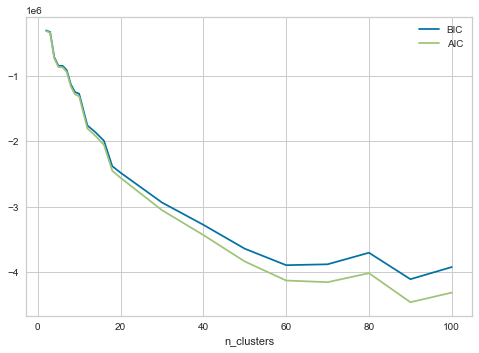

In [109]:
plt.plot(n_clusters, [em_pca_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_pca_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

<h1>EM with ICA</h1>

In [36]:
em_ica_res = defaultdict(dict)
ica80 = FastICA(
    random_state=0,
    n_components=80,
)
ica80_Xt = ica80.fit_transform(X_preprocessed)

for k in n_clusters:
    em = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    em.fit(ica80_Xt)
    run_time = time.perf_counter() - start
    y_em = em.predict(ica80_Xt)
    em_ica_res[k]['bic'] = em.bic(ica80_Xt)
    em_ica_res[k]['aic'] = em.aic(ica80_Xt)
    em_ica_res[k]['ll'] = em.score(ica80_Xt)
    em_ica_res[k]['time'] = run_time
    em_ica_res[k]['sil'] = silhouette_score(ica80_Xt, y_em, random_state=0)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(em_ica_res, "results/em_ica_80_adult.pkl")

done k=2 in 0.271 sec
done k=3 in 0.377 sec
done k=4 in 0.480 sec
done k=5 in 0.673 sec
done k=6 in 0.710 sec
done k=7 in 0.809 sec
done k=8 in 8.853 sec
done k=9 in 15.676 sec
done k=10 in 12.256 sec
done k=12 in 11.231 sec
done k=14 in 33.307 sec
done k=16 in 23.359 sec
done k=18 in 19.259 sec
done k=20 in 35.097 sec
done k=30 in 42.641 sec
done k=40 in 38.925 sec
done k=50 in 109.047 sec
done k=60 in 70.487 sec
done k=70 in 58.705 sec
done k=80 in 71.903 sec
done k=90 in 60.986 sec
done k=100 in 128.644 sec


['results/em_ica_80_adult.pkl']

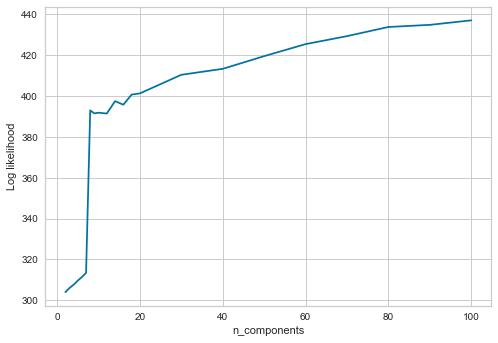

In [37]:
plt.plot(n_clusters, [em_ica_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

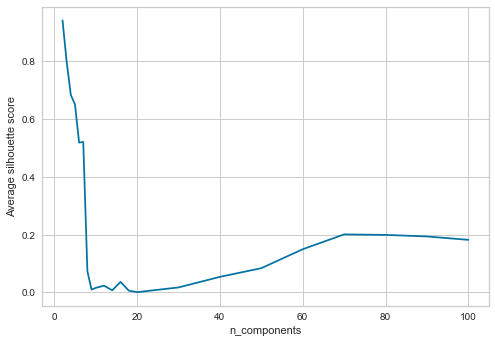

In [38]:
plt.plot(n_clusters, [em_ica_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.show()

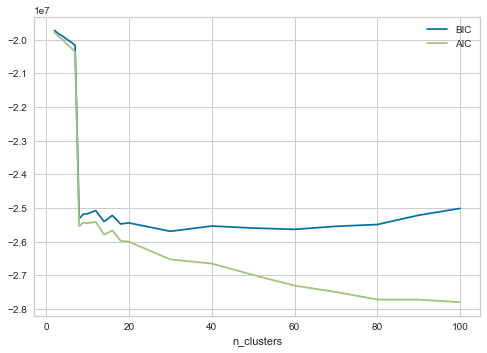

In [39]:
plt.plot(n_clusters, [em_ica_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_ica_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

<h1>EM with RP</h1>

In [114]:
em_rp_res = defaultdict(dict)
rp19 = SparseRandomProjection(n_components=19, random_state = 0)

rp19_Xt = rp19.fit_transform(X_norm)

for k in n_clusters:
    em = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    em.fit(rp19_Xt)
    run_time = time.perf_counter() - start
    y_em = em.predict(rp19_Xt)
    em_rp_res[k]['bic'] = em.bic(rp19_Xt)
    em_rp_res[k]['aic'] = em.aic(rp19_Xt)
    em_rp_res[k]['ll'] = em.score(rp19_Xt)
    em_rp_res[k]['time'] = run_time
    em_rp_res[k]['sil'] = silhouette_score(rp19_Xt, y_em, random_state=0)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         km_pca_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(em_rp_res, "results/em_rp_adult.pkl")

done k=2 in 0.479 sec
done k=3 in 0.630 sec
done k=4 in 0.836 sec
done k=5 in 1.532 sec
done k=6 in 1.775 sec
done k=7 in 1.976 sec
done k=8 in 1.847 sec
done k=9 in 1.934 sec
done k=10 in 2.629 sec
done k=12 in 4.603 sec
done k=14 in 5.343 sec
done k=16 in 8.425 sec
done k=18 in 7.958 sec
done k=20 in 6.838 sec
done k=30 in 9.331 sec
done k=40 in 14.532 sec
done k=50 in 17.907 sec
done k=60 in 24.792 sec
done k=70 in 30.110 sec
done k=80 in 42.745 sec
done k=90 in 37.921 sec
done k=100 in 41.198 sec


['results/em_rp_adult.pkl']

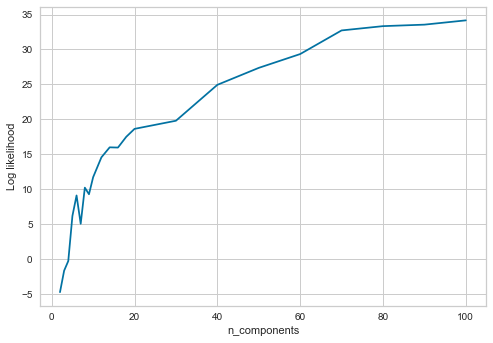

In [115]:
plt.plot(n_clusters, [em_rp_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

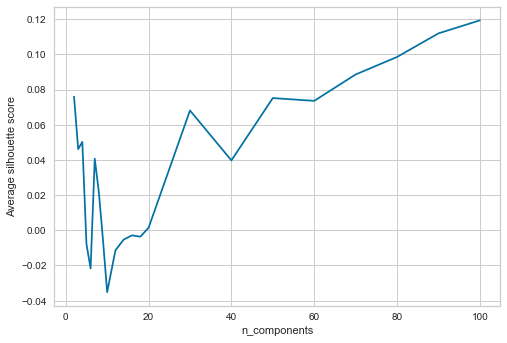

In [116]:
plt.plot(n_clusters, [em_rp_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.show()

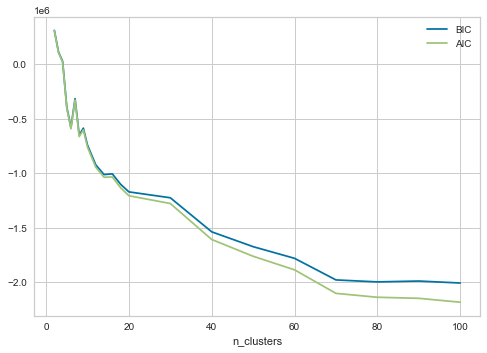

In [117]:
plt.plot(n_clusters, [em_rp_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_rp_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

<h1>EM with SVD</h1>

In [121]:
em_svd_res = defaultdict(dict)
svd24 = TruncatedSVD(n_components=24, random_state = 0)

svd24_Xt = svd24.fit_transform(X_norm)

for k in n_clusters:
    em = GaussianMixture(
        n_components=k,
        random_state=0,
        init_params='kmeans',
    )
    start = time.perf_counter()
    em.fit(svd24_Xt)
    run_time = time.perf_counter() - start
    y_em = em.predict(svd24_Xt)
    em_svd_res[k]['bic'] = em.bic(svd24_Xt)
    em_svd_res[k]['aic'] = em.aic(svd24_Xt)
    em_svd_res[k]['ll'] = em.score(svd24_Xt)
    em_svd_res[k]['time'] = run_time
    em_svd_res[k]['sil'] = silhouette_score(svd24_Xt, y_em, random_state=0)
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         km_pca_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, run_time))

joblib.dump(em_svd_res, "results/em_svd_adult.pkl")

done k=2 in 0.157 sec
done k=3 in 0.259 sec
done k=4 in 0.482 sec
done k=5 in 1.334 sec
done k=6 in 1.168 sec
done k=7 in 1.521 sec
done k=8 in 0.937 sec
done k=9 in 1.077 sec
done k=10 in 1.408 sec
done k=12 in 1.703 sec
done k=14 in 2.760 sec
done k=16 in 6.083 sec
done k=18 in 6.048 sec
done k=20 in 4.289 sec
done k=30 in 6.022 sec
done k=40 in 9.096 sec
done k=50 in 15.576 sec
done k=60 in 20.254 sec
done k=70 in 24.302 sec
done k=80 in 24.120 sec
done k=90 in 34.425 sec
done k=100 in 41.008 sec


['results/em_svd_adult.pkl']

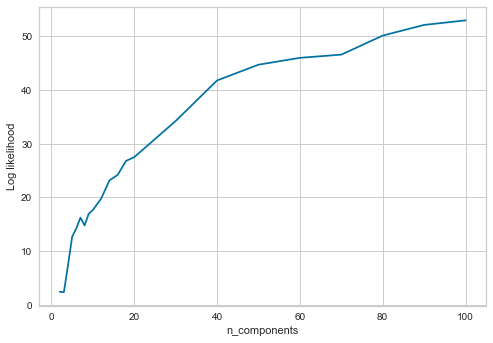

In [122]:
plt.plot(n_clusters, [em_svd_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

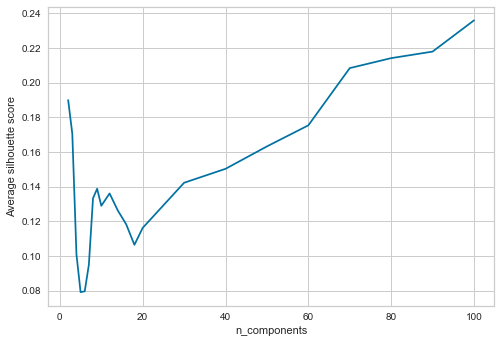

In [123]:
plt.plot(n_clusters, [em_svd_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.show()

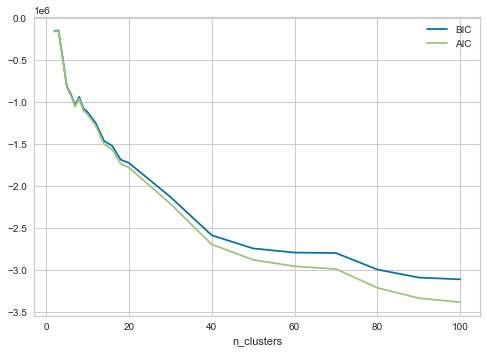

In [124]:
plt.plot(n_clusters, [em_svd_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_svd_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

<h1>Other</h1>

In [14]:
accuracy_score(y_pred, y_test)

0.7155287132766915

In [15]:
    data = pd.read_csv(
        'data/adult.data',
        names=[
        "age", "workclass", "fnlwgt", "education", "education-num", "marital status",
        "occupation", "relationship", "race", "sex", "capital gain", "capital loss",
        "hours per week", "country", "target"]
    )

In [16]:
data

,age,workclass,fnlwgt,education,education-num,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [19]:
data.dropna()
data['country'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

In [21]:
country_replacement = {}
i = 0
for country in data['country'].unique():
    country_replacement[country] = i
    i += 1
    

In [23]:
data.replace({'country': country_replacement})

,age,workclass,fnlwgt,education,education-num,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,0,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,0,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,0,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,0,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,1,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,0,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,0,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,0,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,0,<=50K


In [29]:
data['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [30]:
data['education'].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [31]:
data['relationship'].unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

In [32]:
data['occupation'].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [33]:
replace_questions = {' ?': None}
for col in data.columns:
    data.replace({col: replace_questions})

In [34]:
data

,age,workclass,fnlwgt,education,education-num,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
